In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from google.colab import files
import shutil
from tqdm.auto import tqdm

In [ ]:
!wget -q -O training_files.zip https://www.dropbox.com/scl/fi/uz7ps4tay0llvktz3717q/atleast_100_png.zip?rlkey=p79ow9qnyygl6r5bdokdzsv20&dl=0
!wget -q -O atleast_100.csv https://www.dropbox.com/scl/fi/8vkxt7qbcznhptdi7gol9/atleast_100.csv?rlkey=vgkwklkcu80eqzy9xshgh5q9h&dl=0
!unzip -q 'training_files.zip'

In [ ]:
def read_file_paths(main_directory):
    main_directory = main_directory
    file_paths = []

    # go through all folders and get the paths of all .ogg audio files
    for root, directories, files in os.walk(main_directory):
        for file in files:
            if file.endswith('.png'):
                file_path = os.path.join(root, file)
                file_paths.append(file_path)

    # os.walk may not go in alphabetical order thus it needs to be sorted
    file_paths.sort()
    return file_paths

In [ ]:
# Creating the dict with the numerical categories to each filepath
df = pd.read_csv('atleast_100.csv')
df.drop(columns=['Unnamed: 0'], inplace=True)
df['Category'] = range(len(df))
# Creating the dictionary that maps the labels to the filepaths
labelmapper = {filename: df[df['Bird'] == filename.split(os.path.sep)[-2]]['Category'].values[0] for filename in read_file_paths('spectrograms')}
# Splitting the data
filepaths = list(labelmapper.keys())
labels = list(labelmapper.values())
train_paths, test_paths, _,  _ = train_test_split(filepaths, labels, test_size=0.1, random_state=42, stratify=labels)
# Create directories for training and validation data
os.makedirs('train', exist_ok=True)
os.makedirs('validation', exist_ok=True)
# Creating the subdirectories with the bird names
for bird in df['Bird']:
    os.makedirs(os.path.join('train', bird), exist_ok=True)
    os.makedirs(os.path.join('validation', bird), exist_ok=True)
# Moving the files to the train and validation folders
for filepath in train_paths:
    shutil.move(filepath, os.path.join('train', filepath.split(os.path.sep)[-2], filepath.split(os.path.sep)[-1]))
for filepath in test_paths:
    shutil.move(filepath, os.path.join('validation', filepath.split(os.path.sep)[-2], filepath.split(os.path.sep)[-1]))
# Deleting the original directory
shutil.rmtree('spectrograms')

In [ ]:
batch_size = 128
# Create an ImageDataGenerator for training data
# Datagenerator for training
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    'train',
    target_size=(128, 312),
    batch_size=batch_size,
    class_mode='categorical'
)
# Datagenerator for validation
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
valid_generator = valid_datagen.flow_from_directory(
    'validation',
    target_size=(128, 312),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 63464 images belonging to 130 classes.
Found 7052 images belonging to 130 classes.


In [ ]:
# Get class indices from the generator
class_indices = train_generator.class_indices
class_labels = list(class_indices.values())
# Calculate class weights
class_weights = class_weight.compute_class_weight('balanced', classes=class_labels, y=train_generator.classes)
# Map class weights
class_weights_dict = {}
for i, class_label in enumerate(class_labels):
    class_weights_dict[class_label] = class_weights[i]

In [ ]:
# Defining callbacks
es = tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss', verbose=1)
mc = tf.keras.callbacks.ModelCheckpoint(filepath='best_model.h5', save_best_only=True, verbose=1)

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(32, (5,5), activation='relu', input_shape=(128, 312, 3)))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Conv2D(16, (5,5), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(130, activation='softmax'))
model.compile('Adam', loss='CategoricalCrossentropy', metrics=['accuracy', 'categorical_crossentropy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 308, 32)      2432      
                                                                 
 dropout (Dropout)           (None, 124, 308, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 62, 154, 32)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 58, 150, 16)       12816     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 29, 75, 16)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 34800)             0

In [ ]:
num_epochs = 3

history = model.fit(train_generator,
                    epochs=num_epochs,
                    validation_data=valid_generator,
                    callbacks=[es, mc],
                    class_weight=class_weights_dict,
                    workers=6,  # Adjust the number of workers based on your system capabilities
                    use_multiprocessing=True)

model.save('final_model.h5')

Epoch 1/3
496/496 [==============================] - ETA: 0s - loss: 4.0549 - accuracy: 0.1387 - categorical_crossentropy: 4.0855 - precision: 0.7258 - recall: 0.0390
Epoch 1: val_loss improved from inf to 3.36438, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


496/496 [==============================] - 333s 637ms/step - loss: 4.0549 - accuracy: 0.1387 - categorical_crossentropy: 4.0855 - precision: 0.7258 - recall: 0.0390 - val_loss: 3.3644 - val_accuracy: 0.2686 - val_categorical_crossentropy: 3.3644 - val_precision: 0.9128 - val_recall: 0.0475
Epoch 2/3
496/496 [==============================] - ETA: 0s - loss: 2.4573 - accuracy: 0.3828 - categorical_crossentropy: 2.6667 - precision: 0.7657 - recall: 0.2069
Epoch 2: val_loss improved from 3.36438 to 2.52938, saving model to best_model.h5
496/496 [==============================] - 312s 622ms/step - loss: 2.4573 - accuracy: 0.3828 - categorical_crossentropy: 2.6667 - precision: 0.7657 - recall: 0.2069 - val_loss: 2.5294 - val_accuracy: 0.4251 - val_categorical_crossentropy: 2.5294 - val_precision: 0.8560 - val_recall: 0.1686
Epoch 3/3
496/496 [==============================] - ETA: 0s - loss: 1.5178 - accuracy: 0.5340 - categorical_crossentropy: 1.9588 - precision: 0.7994 - recall: 0.3960
Ep

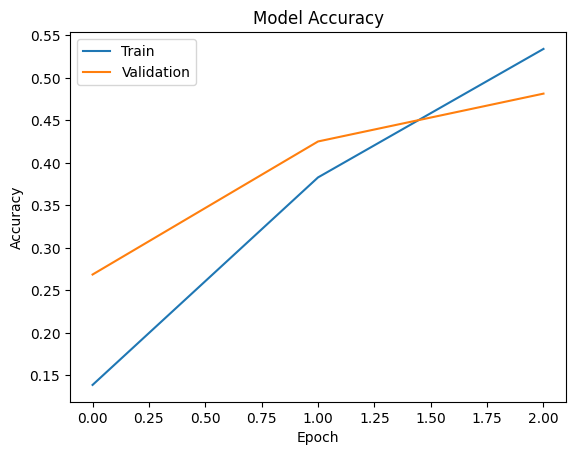

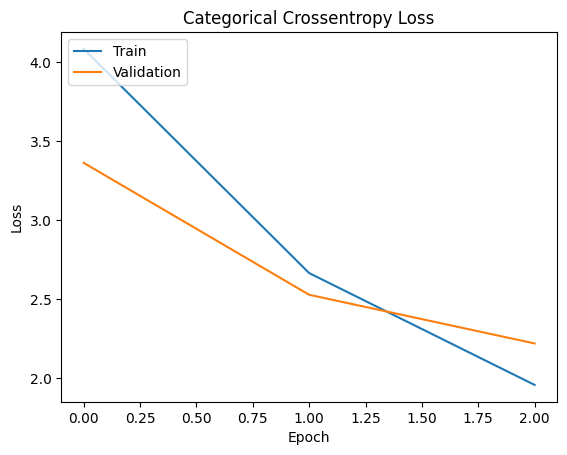

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['categorical_crossentropy'])
plt.plot(history.history['val_categorical_crossentropy'])
plt.title('Categorical Crossentropy Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [ ]:
train_datagen_augment = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                        width_shift_range=0.1,
                                                                        height_shift_range=0.1,
                                                                        shear_range=0.1,
                                                                        zoom_range=0.05,
                                                                        fill_mode='nearest')
train_generator_aug = train_datagen_augment.flow_from_directory(
    'train',
    target_size=(128, 312),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 63464 images belonging to 130 classes.


In [ ]:
num_epochs = 10

history = model.fit(train_generator_aug,
                    epochs=num_epochs,
                    validation_data=valid_generator,
                    callbacks=[es, mc],
                    class_weight=class_weights_dict,
                    workers=6,  # Adjust the number of workers based on your system capabilities
                    use_multiprocessing=True)

model.save('final_model.h5')

Epoch 1/10
496/496 [==============================] - ETA: 0s - loss: 4.9203 - accuracy: 0.0117 - categorical_crossentropy: 4.8733 - precision: 0.0942 - recall: 4.5695e-04
Epoch 1: val_loss did not improve from 2.06197
496/496 [==============================] - 885s 2s/step - loss: 4.9203 - accuracy: 0.0117 - categorical_crossentropy: 4.8733 - precision: 0.0942 - recall: 4.5695e-04 - val_loss: 4.8034 - val_accuracy: 0.0089 - val_categorical_crossentropy: 4.8034 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
496/496 [==============================] - ETA: 0s - loss: 4.7429 - accuracy: 0.0154 - categorical_crossentropy: 4.7307 - precision: 0.2908 - recall: 6.4604e-04
Epoch 2: val_loss did not improve from 2.06197
496/496 [==============================] - 869s 2s/step - loss: 4.7429 - accuracy: 0.0154 - categorical_crossentropy: 4.7307 - precision: 0.2908 - recall: 6.4604e-04 - val_loss: 4.5246 - val_accuracy: 0.0518 - val_categorical_crossentropy: 4.5246 - val_precision

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
num_epochs = 20

history = model.fit(train_generator_aug,
                    epochs=num_epochs,
                    validation_data=valid_generator,
                    callbacks=[es, mc],
                    class_weight=class_weights_dict,
                    workers=6,  # Adjust the number of workers based on your system capabilities
                    use_multiprocessing=True)

model.save('final_model.h5')

Epoch 1/20
496/496 [==============================] - ETA: 0s - loss: 2.9057 - accuracy: 0.3232 - categorical_crossentropy: 2.9344 - precision: 0.7410 - recall: 0.1198
Epoch 1: val_loss did not improve from 2.06197
496/496 [==============================] - 924s 2s/step - loss: 2.9057 - accuracy: 0.3232 - categorical_crossentropy: 2.9344 - precision: 0.7410 - recall: 0.1198 - val_loss: 2.8289 - val_accuracy: 0.3460 - val_categorical_crossentropy: 2.8289 - val_precision: 0.8496 - val_recall: 0.0817
Epoch 2/20
496/496 [==============================] - ETA: 0s - loss: 2.8090 - accuracy: 0.3354 - categorical_crossentropy: 2.8621 - precision: 0.7355 - recall: 0.1350
Epoch 2: val_loss did not improve from 2.06197
496/496 [==============================] - 884s 2s/step - loss: 2.8090 - accuracy: 0.3354 - categorical_crossentropy: 2.8621 - precision: 0.7355 - recall: 0.1350 - val_loss: 2.7404 - val_accuracy: 0.3518 - val_categorical_crossentropy: 2.7404 - val_precision: 0.8158 - val_recall: 0

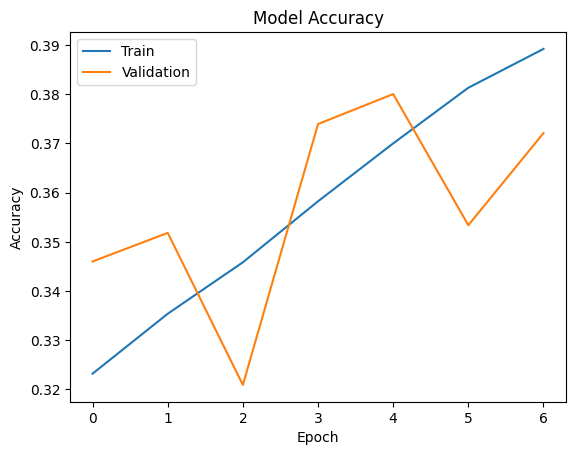

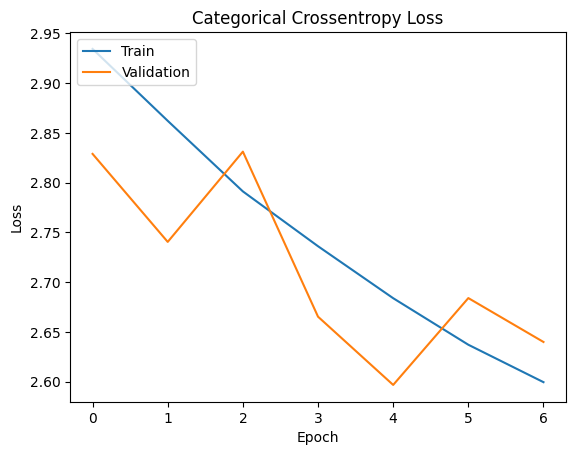

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['categorical_crossentropy'])
plt.plot(history.history['val_categorical_crossentropy'])
plt.title('Categorical Crossentropy Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
from google.colab import files

files.download('final_model.h5')
files.download('best_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>